In [1]:
import os 
import matplotlib
import calendar

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt

In [64]:
# Folder path containing the CSV files
folder_path = '../data/raw/physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data'
file_path = '../data/raw/physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv'
plt.rcParams['figure.figsize'] = (20, 8)

In [4]:
def read_single_file(file_path):
    df = pd.read_csv(file_path)
    return df
    
    # select by activity and plot them
    

single_df = read_single_file(file_path)

In [5]:
def read_all_data(folder_path):
    # List to store the DataFrames
    data_frames = []
    for filename in os.listdir(folder_path):
        
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path,filename)
            df = pd.read_csv(file_path)
            data_frames.append(df)
        else:
            print(f"{filename} is not a csv file")
        
    return data_frames 
    # print(df.head(5))


data_frames = read_all_data(folder_path)
combined_df = pd.concat(data_frames)




index.html is not a csv file


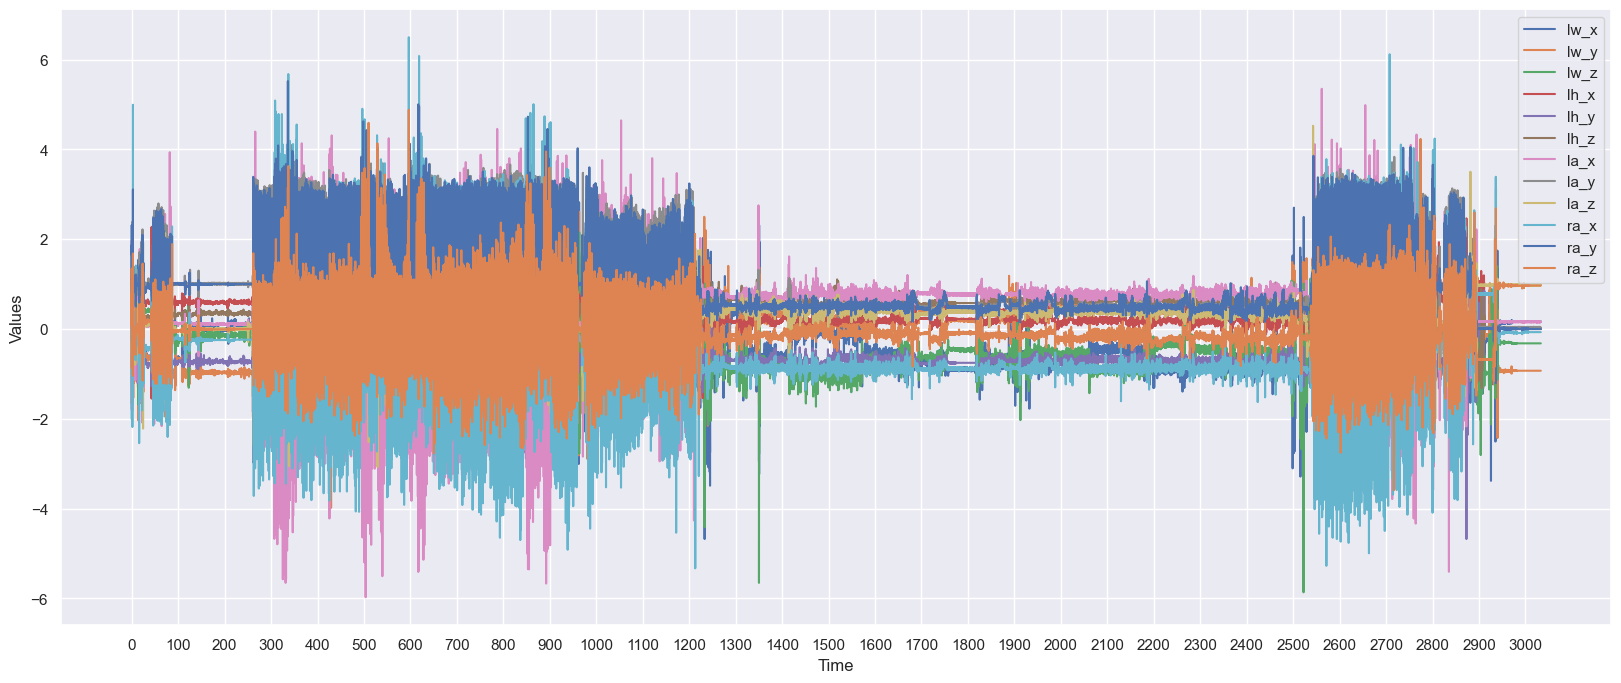

In [57]:
def plot_all(df):
    sns.set_theme(context='notebook', style='darkgrid', palette="deep")
    variables = ["lw_x", "lw_y", "lw_z", "lh_x", "lh_y", "lh_z", "la_x", "la_y", "la_z", "ra_x", "ra_y", "ra_z"]
    df.plot(x='time_s', y=variables)
    tick_positions = range(0, 3034, 100) 
    plt.xticks(tick_positions)
    # Adding labels and a legend
    
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend(variables)
    
    # Displaying the plot
    plt.show()
# plot(combined_df)
plot_all(single_df)


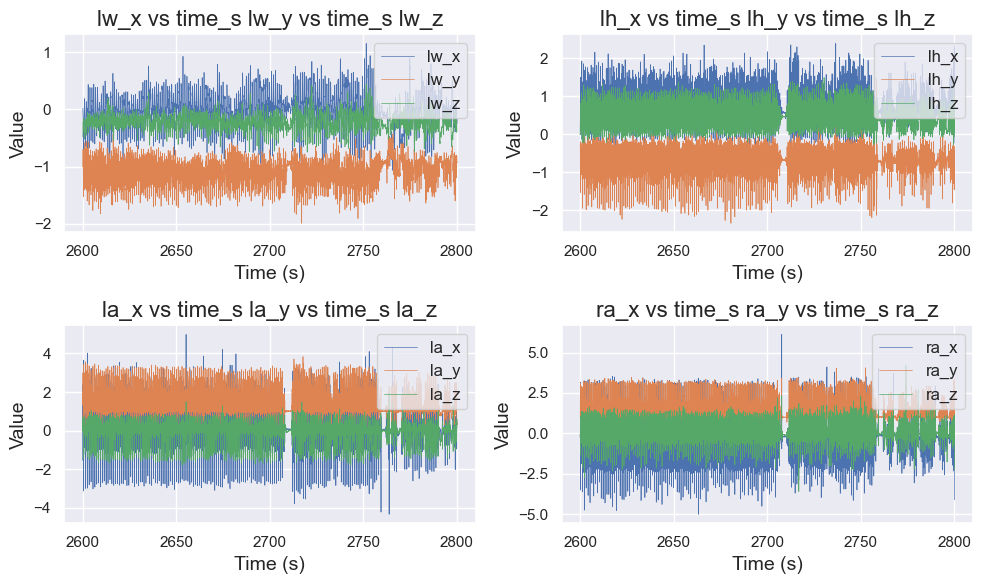

In [118]:


# colors = ["#F7F3E3","#7F7CAF","#78C0E0"]
# colors = ["#FFF8F0","#9DD9D2","#8981A5"]
option_colors = sns.color_palette()
colors =[option_colors[0],option_colors[1],option_colors[2]]

# assuming single_df is your DataFrame
df_99 = single_df[single_df['activity'] == 99]
df_99 = df_99[(df_99['time_s'] >= 2600) & (df_99['time_s'] <= 2800)]

# create larger subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Plotting
for i, (ax, variables) in enumerate(zip(axs.flat, [('lw_x', 'lw_y', 'lw_z'), ('lh_x', 'lh_y', 'lh_z'), ('la_x', 'la_y', 'la_z'), ('ra_x', 'ra_y', 'ra_z')])):
    for variable, color in zip(variables, colors):
        sns.lineplot(data=df_99, x='time_s', y=variable, ax=ax, linewidth=0.5, color=color, label=variable)
    
    ax.legend(loc='upper right', fontsize=12)
    ax.set_title(' vs time_s '.join(variables), fontsize=16)
    ax.set_xlabel('Time (s)', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [121]:
def make_x_y_z_plot(df):
    # colors = ["#F7F3E3","#7F7CAF","#78C0E0"]
    option_colors = sns.color_palette()
    colors =[option_colors[0],option_colors[1],option_colors[2]]
    # create larger subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        # Plotting
    for i, (ax, variables) in enumerate(zip(axs.flat, [('lw_x', 'lw_y', 'lw_z'), ('lh_x', 'lh_y', 'lh_z'), ('la_x', 'la_y', 'la_z'), ('ra_x', 'ra_y', 'ra_z')])):
        for variable, color in zip(variables, colors):
            sns.lineplot(data=df, x='time_s', y=variable, ax=ax, linewidth=0.5, color=color, label=variable)
        
        ax.legend(loc='upper right', fontsize=12)
        ax.set_title(' vs time_s '.join(variables), fontsize=16)
        ax.set_xlabel('Time (s)', fontsize=14)
        ax.set_ylabel('Value', fontsize=14)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    

In [139]:
# show the period of each activity
def show_x_y_z_plot(df,activity):
    if activity == 99:
        df_99 = df[df['activity'] == 99]
        # df_99 = df_99[(df_99['time_s'] >= 2600) & (df_99['time_s'] <= 2800)]
        make_x_y_z_plot(df_99)
    elif activity == 77:
        df_77 = df[df['activity'] == 77]
        # df_77 = df_77[(df_77['time_s'] >= 520) & (df_77['time_s'] <= 540)]
        make_x_y_z_plot(df_77)
    elif activity ==4:
        df_4 = df[df['activity'] == 4]
        # df_4 = df_4[(df_4['time_s'] >= 1400) & (df_4['time_s'] <= 1600)]
        make_x_y_z_plot(df_4)
    elif activity ==3:
        df_3 = df[df['activity'] == 3]
        # df_3 = df_3[(df_3['time_s'] >= 300) & (df_3['time_s'] <= 350)]
        make_x_y_z_plot(df_3)
    elif activity ==2:
        df_2 = df[df['activity'] == 2]
        # df_2 = df_2[(df_2['time_s'] >= 300) & (df_2['time_s'] <= 350)]
        make_x_y_z_plot(df_2)
    elif activity ==1:
        df_1 = df[df['activity'] == 1]
        # df_1 = df_1[(df_1['time_s'] >= 650) & (df_1['time_s'] <= 750)]
        
        make_x_y_z_plot(df_1)




<built-in method values of dict object at 0x327ff28c0>
Now activity is non-study activity and the code is 99


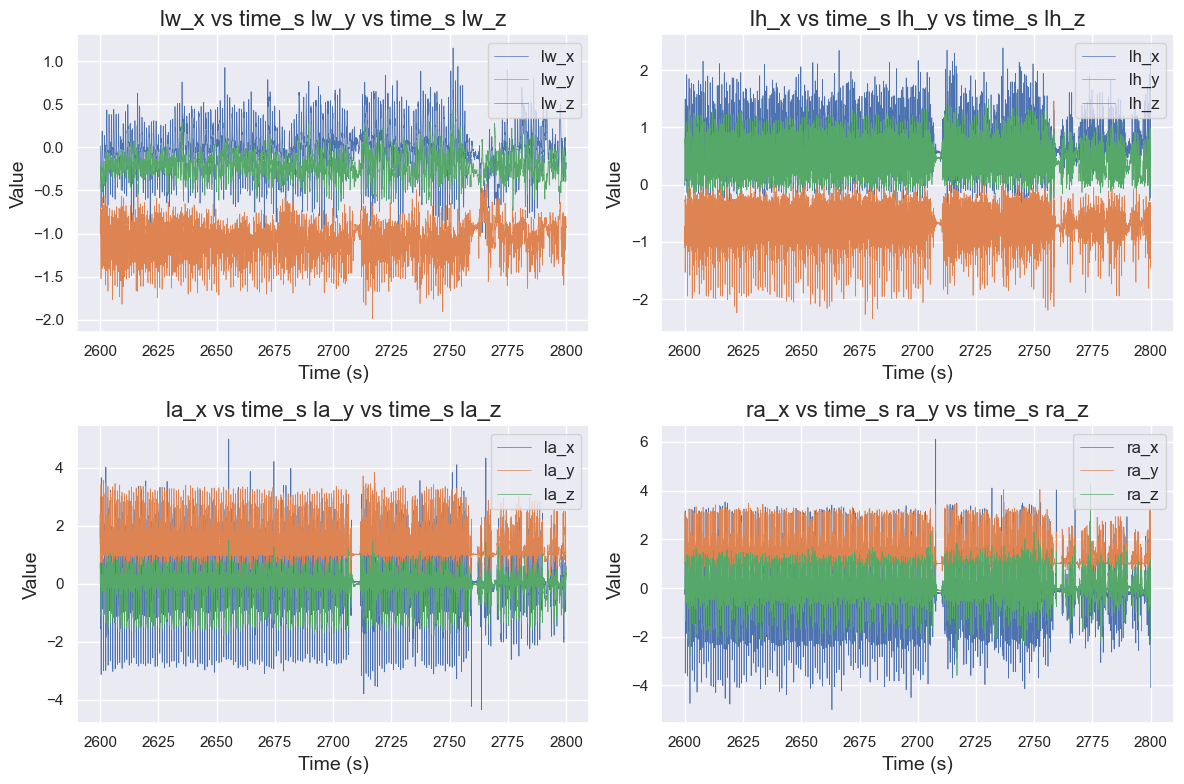

Now activity is clapping and the code is 77


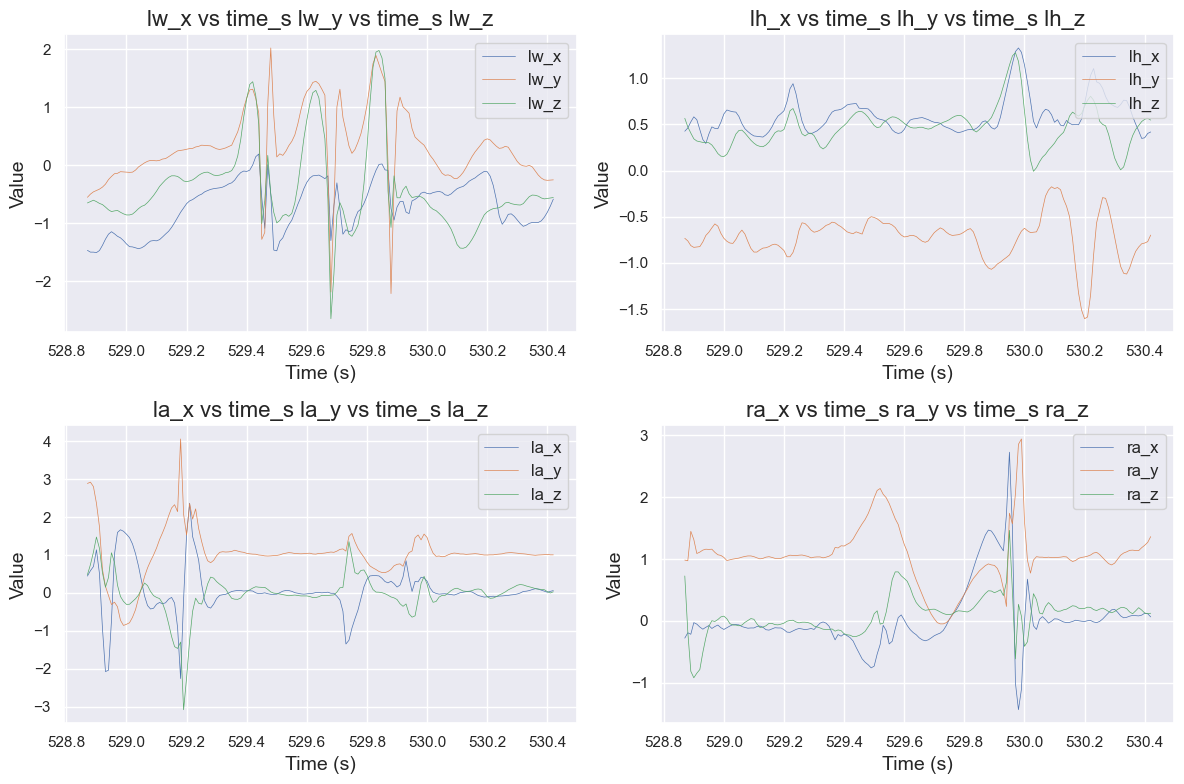

Now activity is driving and the code is 4


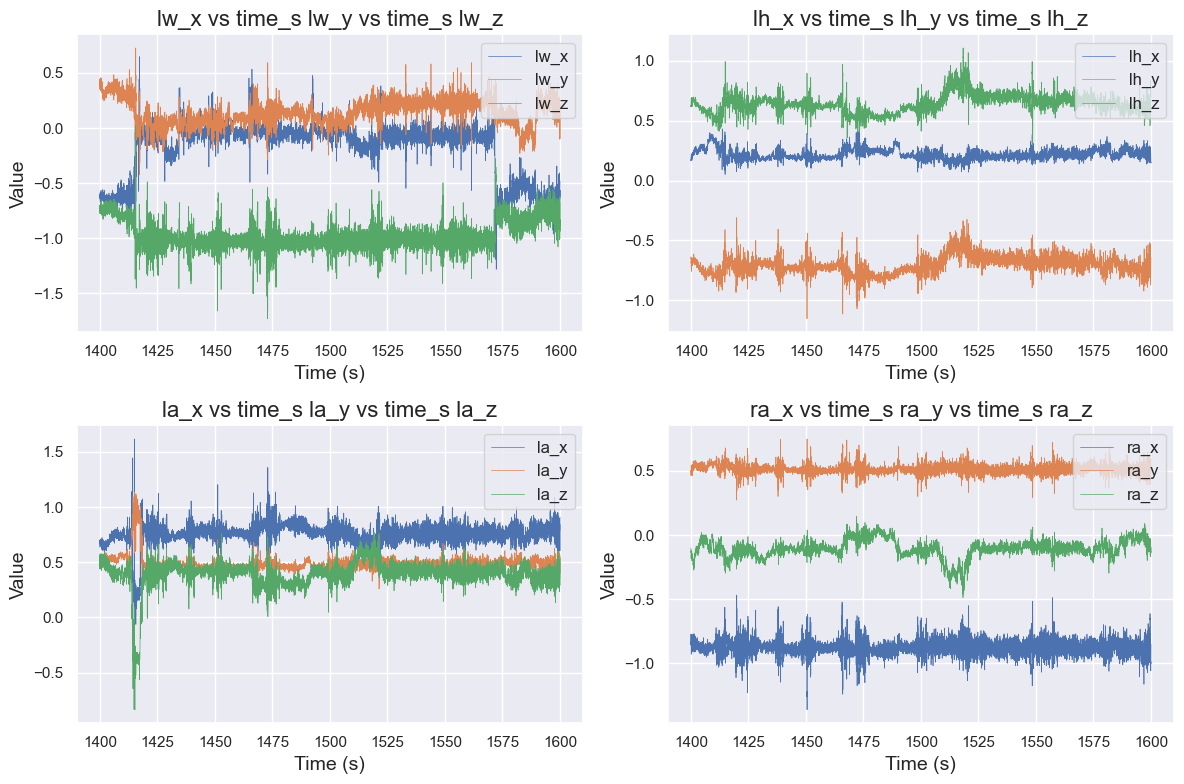

Now activity is ascending stairs and the code is 3


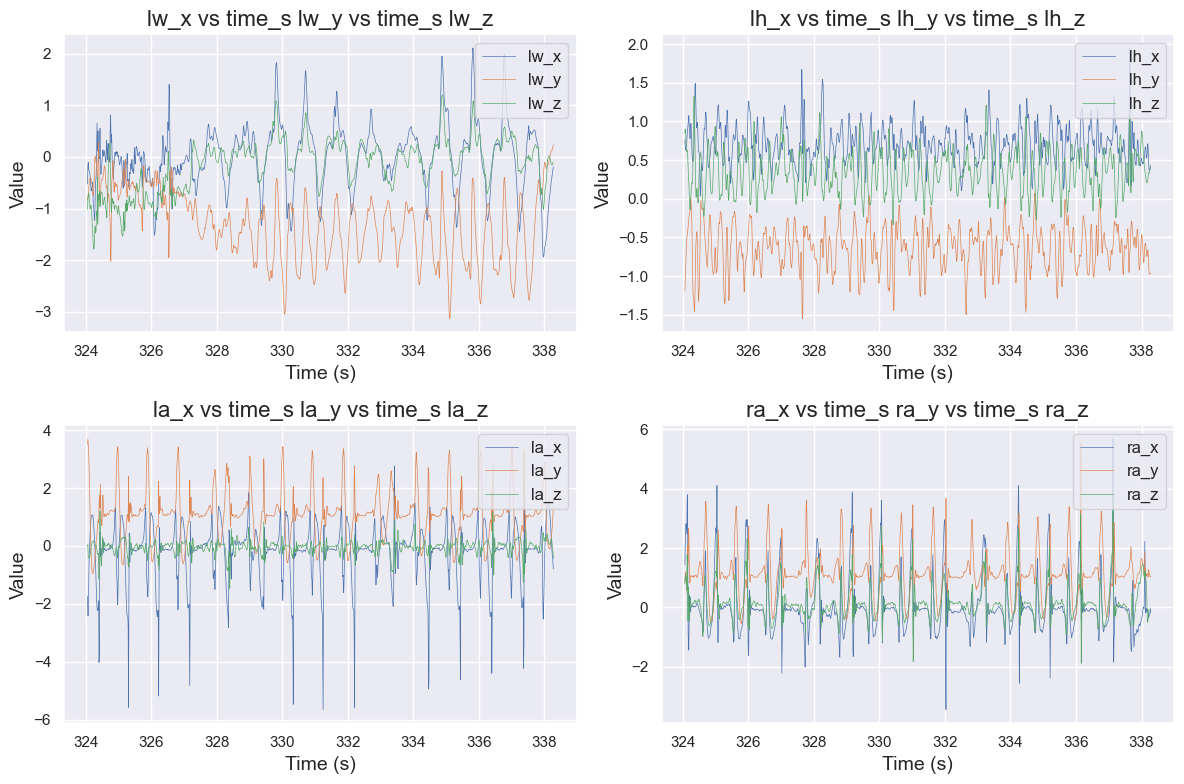

Now activity is descending stairs and the code is 2


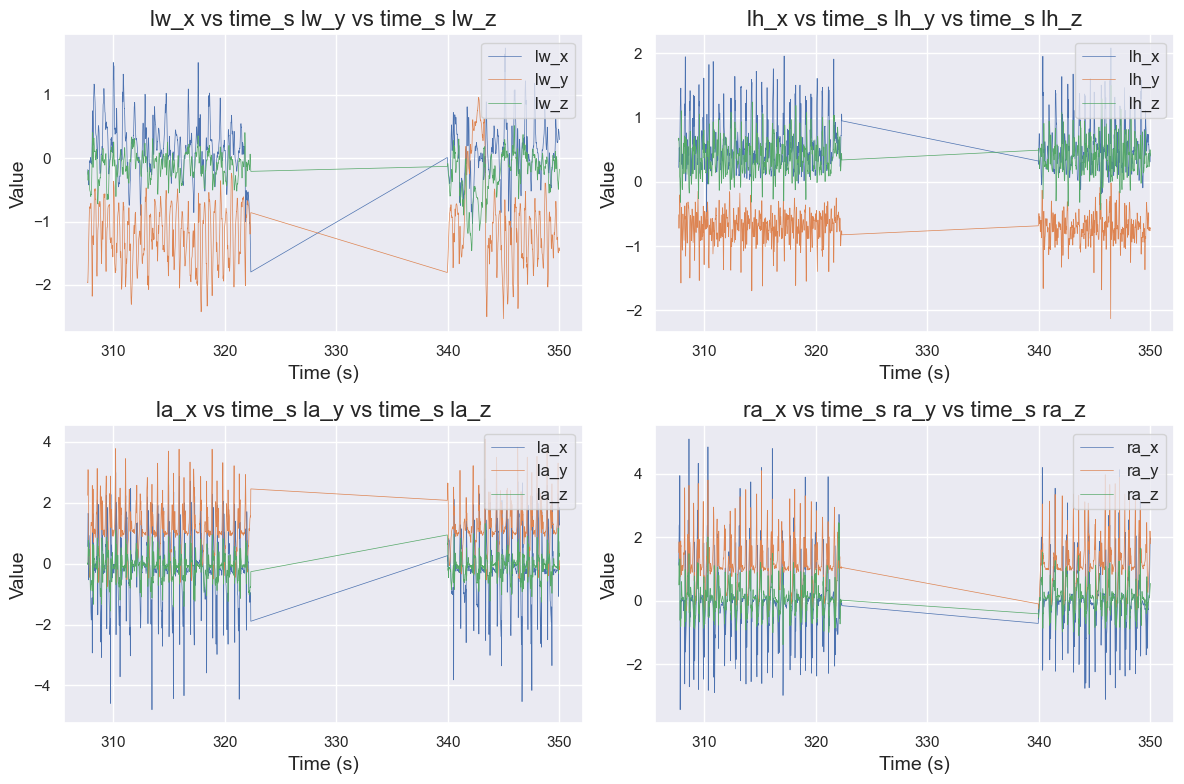

Now activity is walking and the code is 1


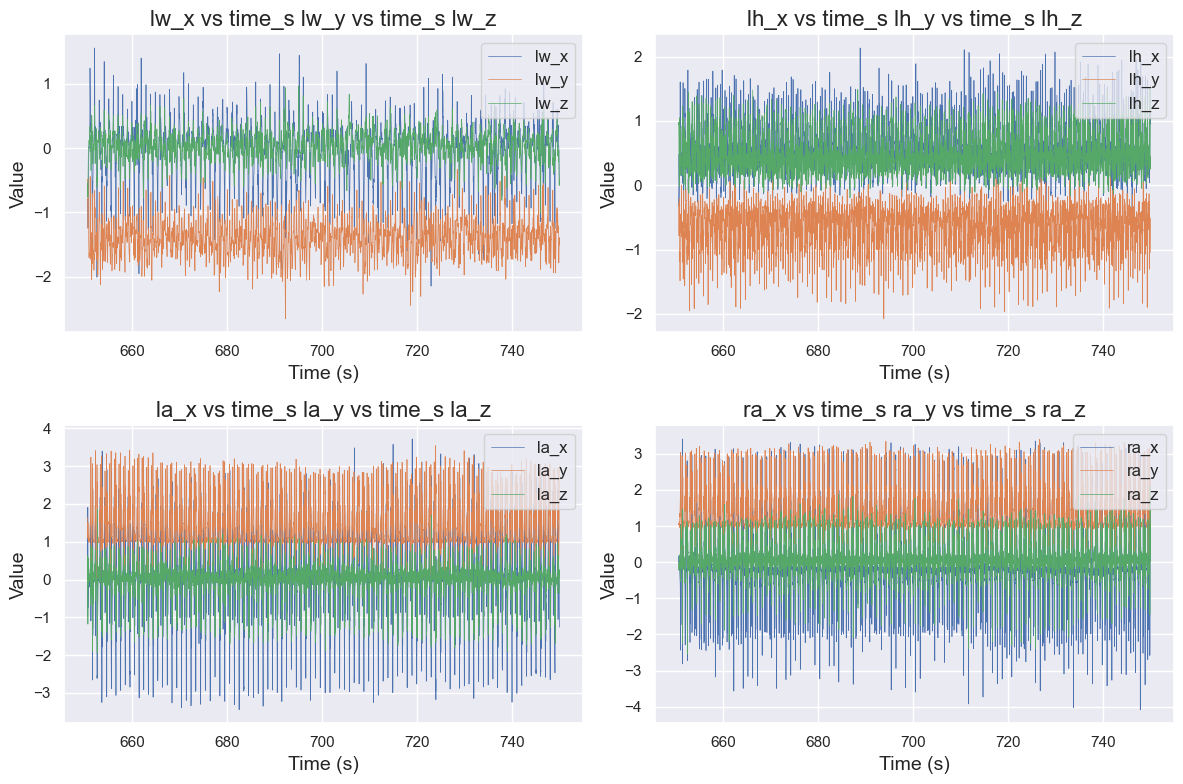

In [127]:
activity_list=[99,77,4,3,2,1]
activity_dict = {
    "non-study activity" : 99,
    "clapping" : 77,
    "driving" : 4,
    "ascending stairs" : 3,
    "descending stairs" : 2,
    "walking": 1
}


print(activity_dict.values)

for activity in activity_dict:
    print(f"Now activity is {activity} and the code is {activity_dict[activity]}")
    show_x_y_z_plot(single_df,activity_dict[activity])

In [140]:
from sklearn.preprocessing import StandardScaler

def standardize_and_downsampling(df):
    # initialize standard scaler
    scaler = StandardScaler()
    # select the columns to standardize
    columns_to_standardize = ["lw_x", "lw_y", "lw_z", "lh_x", "lh_y", "lh_z", "la_x", "la_y", "la_z", "ra_x", "ra_y", "ra_z"]
    # standardize the columns
    df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])


    downsampling_factor = 20
    # # Convert the 'time_s' column to a datetime format if it isn't already
    # df['time_s'] = pd.to_datetime(df['time_s'], unit='s') 

    # # Set the 'time_s' column as the index of the DataFrame
    # df.set_index('time_s', inplace=True)

    # we can use the resample method in pandas to downsample the data
    df_resampled = df.resample(f'{downsampling_factor}L').mean()

        # check if the data has been standardized
    print(df[columns_to_standardize].mean())  # should be close to 0
    print(df[columns_to_standardize].std())   # should be close to 1

    # Reset the index back to RangeIndex
    df_resampled.reset_index(inplace=True)

    # Convert 'time_s' back to its original unit
    df_resampled['time_s'] = df_resampled['time_s'].astype(int)

    return df_resampled




single_df_after_sandd = standardize_and_downsampling(single_df)

lw_x    1.658636e-17
lw_y   -7.496659e-18
lw_z   -5.200807e-18
lh_x   -2.164660e-17
lh_y    1.124499e-18
lh_z    1.874165e-17
la_x    4.441771e-17
la_y   -2.548864e-17
la_z    3.448463e-17
ra_x   -2.951810e-18
ra_y   -3.935746e-18
ra_z    1.236949e-17
dtype: float64
lw_x    1.000002
lw_y    1.000002
lw_z    1.000002
lh_x    1.000002
lh_y    1.000002
lh_z    1.000002
la_x    1.000002
la_y    1.000002
la_z    1.000002
ra_x    1.000002
ra_y    1.000002
ra_z    1.000002
dtype: float64


Now activity is non-study activity and the code is 99


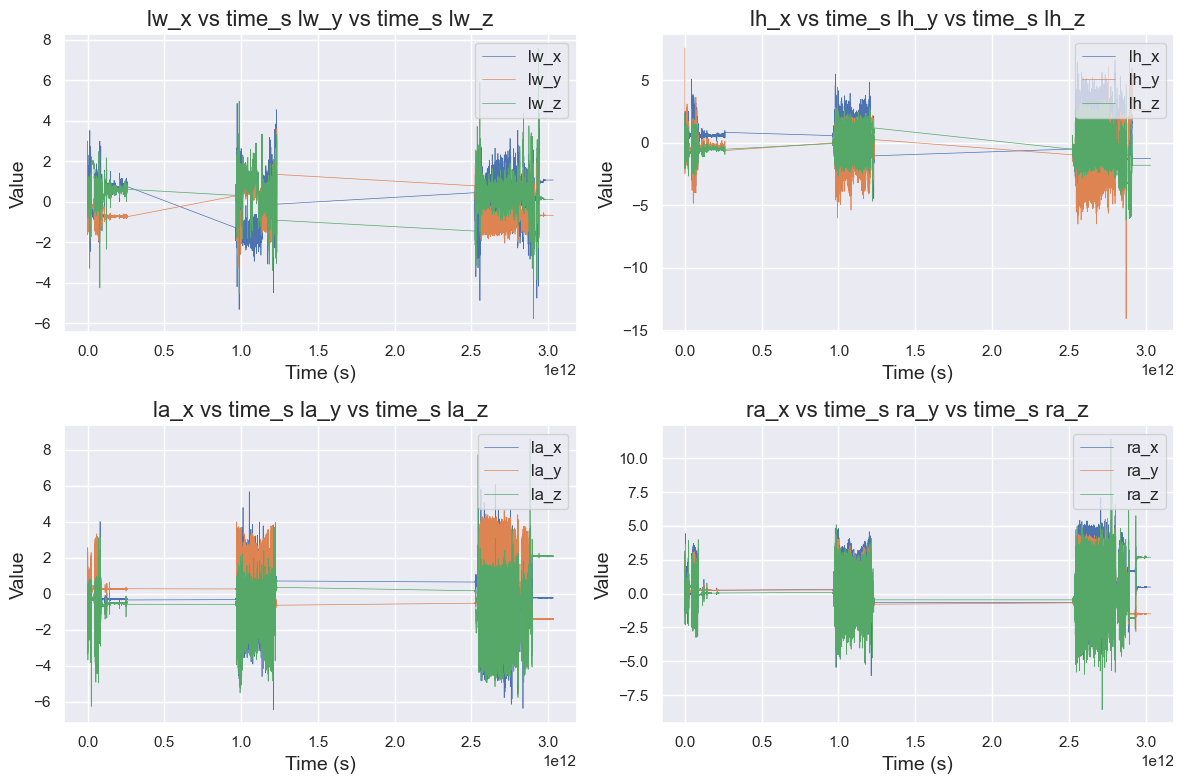

Now activity is clapping and the code is 77


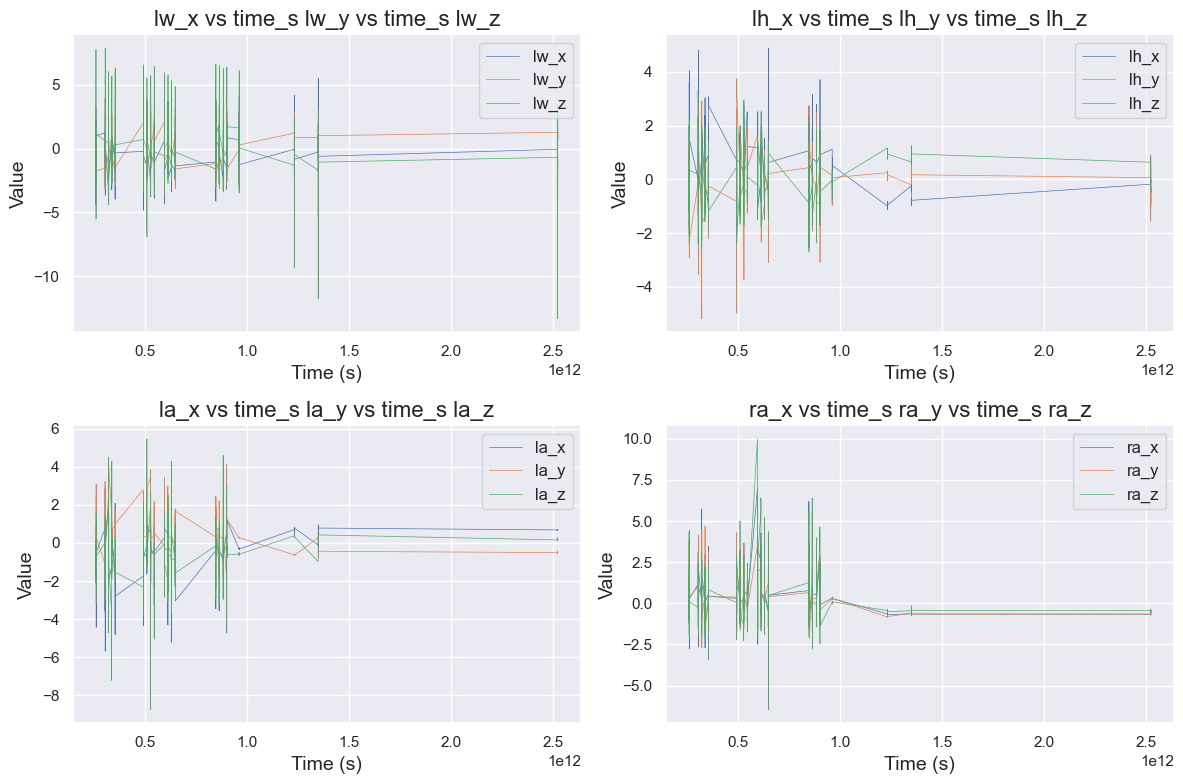

Now activity is driving and the code is 4


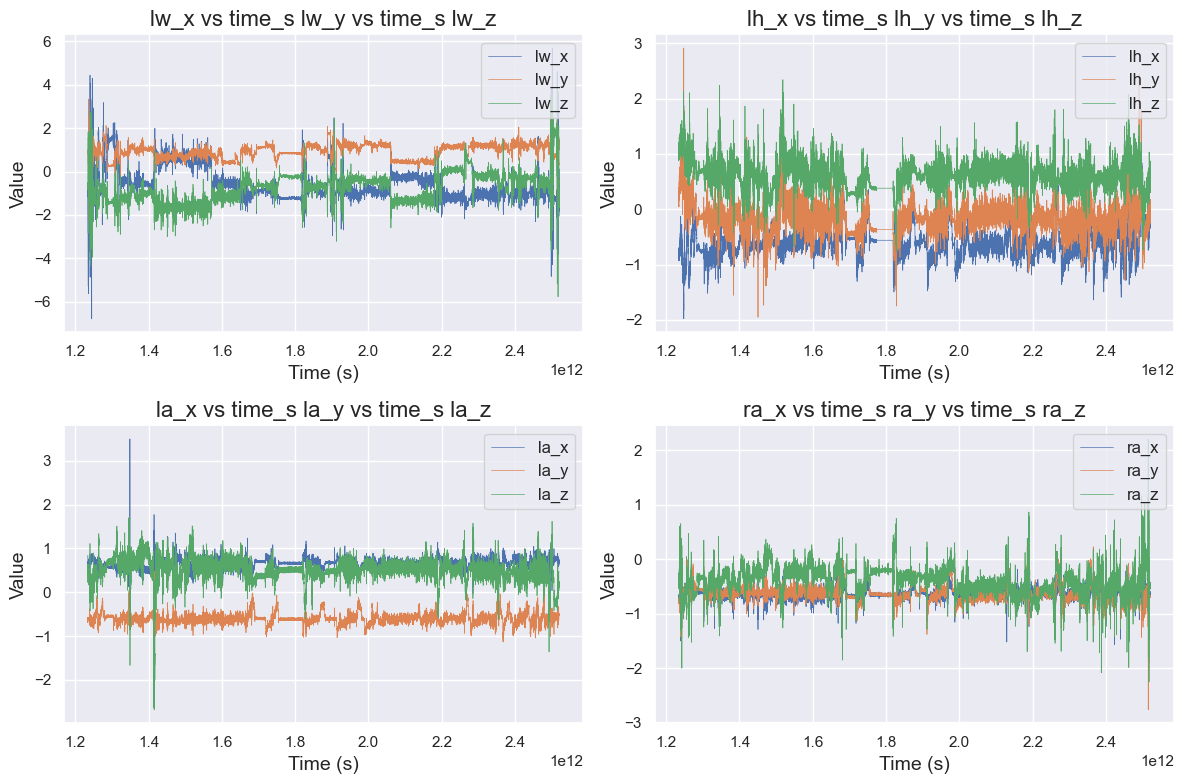

Now activity is ascending stairs and the code is 3


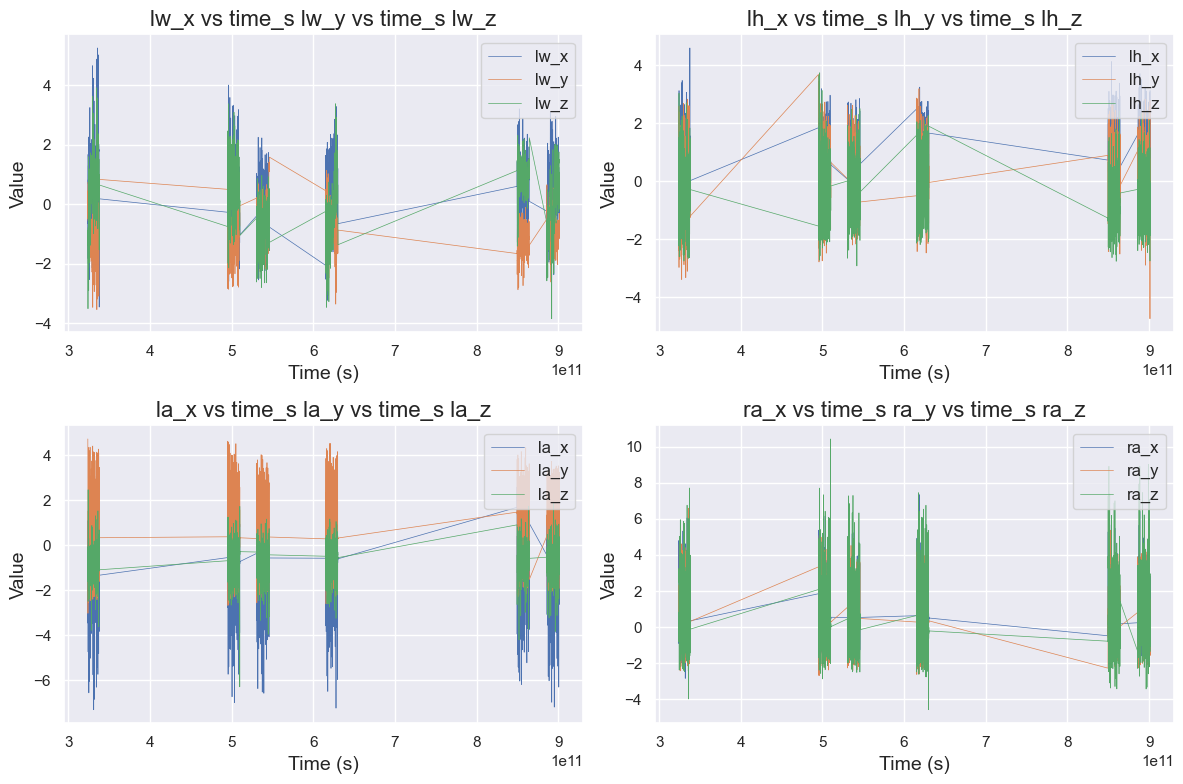

Now activity is descending stairs and the code is 2


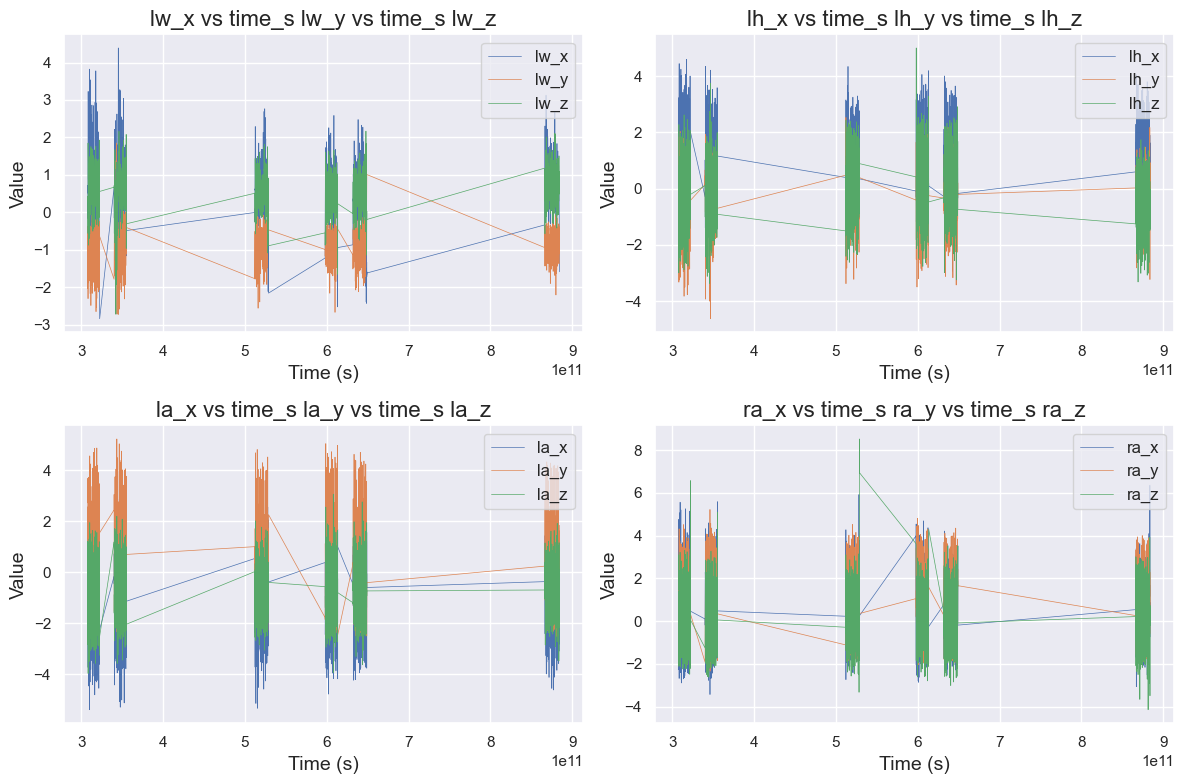

Now activity is walking and the code is 1


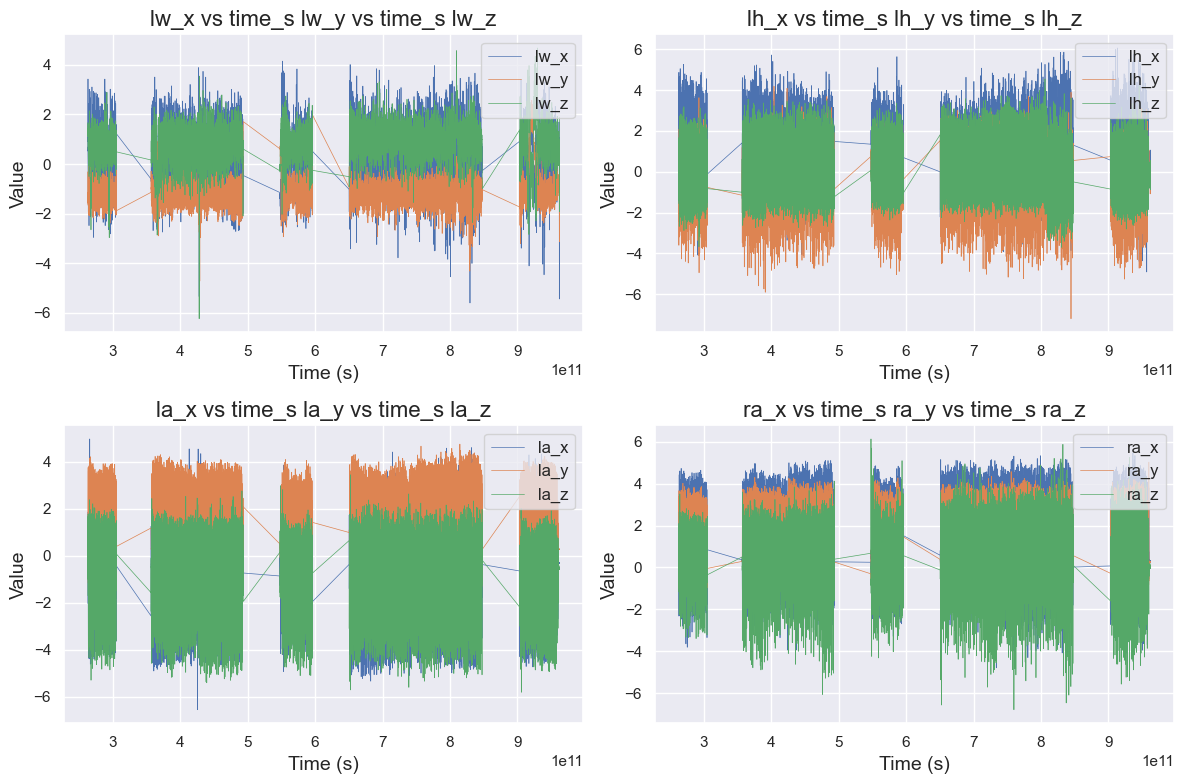

In [141]:
for activity in activity_dict:
    print(f"Now activity is {activity} and the code is {activity_dict[activity]}")
    show_x_y_z_plot(single_df_after_sandd,activity_dict[activity])

In [144]:
def data_segmentation(df_preprocessed):

    # Assuming your preprocessed data is stored in the DataFrame 'df_preprocessed'

    window_size = 3  # Size of each window in seconds
    overlap = 0.5  # Overlap percentage (50%)
    sampling_rate = 1
    # Calculate the number of data points in each window
    window_length = int(window_size * sampling_rate)  # Replace 'sampling_rate' with the actual sampling rate of your data

    # Calculate the number of data points to shift the window by for the given overlap
    shift_length = int(window_length * overlap)

    # Initialize an empty list to store the segmented data
    segmented_data = []

    # Iterate over the data using a sliding window
    start_index = 0
    while start_index + window_length <= len(df_preprocessed):
        end_index = start_index + window_length
        segment = df_preprocessed.iloc[start_index:end_index]
        segmented_data.append(segment)
        start_index += shift_length

    # Concatenate the segmented data into a new DataFrame
    df_segmented = pd.concat(segmented_data)

    # Reset the index of the segmented DataFrame
    df_segmented.reset_index(drop=True, inplace=True)


    return df_segmented


In [145]:
data_processed = data_segmentation(single_df_after_sandd)

In [75]:
def main():
    pass

In [76]:
if __name__ == "__main__":
    main()